In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from arch import arch_model
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from data.stock_data import StockData

In [103]:
# Define the stock data you want to fetch, and fetch it
# Ticker for yahoo finance sp500 data
ticker = '^GSPC'
start_date = '2006-01-01'
end_date='2022-12-31'

sp500 = StockData(ticker, start_date, end_date).fetch_data()

# Drop all the rows where Log Return is exactly 0
sp500 = sp500[sp500['Log Return'] != 0]
sp500 = sp500.dropna()
sp500

# Make the sp500 be on a weekly frequency instead of daily
sp500 = sp500.resample('W').sum()
sp500.to_csv('data/sp500_weekly.csv')

[*********************100%***********************]  1 of 1 completed


In [104]:
sp500

,Log Return,Squared Return
Date,,
2006-01-08,1.303720,1.009653
2006-01-15,0.167896,0.665918
2006-01-22,-2.049422,4.014040
2006-01-29,1.746854,1.239267
2006-02-05,-1.545704,1.323481
...,...,...
2022-12-04,1.125743,11.759279
2022-12-11,-3.430731,6.504358
2022-12-18,-2.106730,10.530129


In [105]:
macro_df = pd.read_csv('data/macro_data.csv')
macro_df

,Year-Month,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change
0,2006-02,0.137,0.268000,0.001604,-0.095848,-0.387820,0.021277
1,2006-03,0.008,0.435000,0.006086,0.085002,-0.234848,-0.020833
2,2006-04,0.135,0.088999,-0.002866,0.078793,0.183086,0.000000
3,2006-05,0.065,0.114000,-0.017775,-0.008208,0.620932,-0.021277
4,2006-06,0.145,-0.055000,0.015713,0.037733,0.152099,0.000000
...,...,...,...,...,...,...,...
205,2023-03,-0.125,-0.157000,0.005933,-0.017911,-1.050639,-0.027778
206,2023-04,0.338,-0.505000,-0.008239,0.014669,-0.054654,-0.028571
207,2023-05,0.325,0.198000,0.007552,-0.113181,-0.882711,0.088235
208,2023-06,-0.095,0.602000,0.004591,0.037450,-1.078431,-0.027027


In [106]:
# Calculate the monthly RV
sp500['YearMonth'] = sp500.index.to_period('M')
monthly_sum = sp500.groupby('YearMonth')['Squared Return'].transform('sum')
sp500['RV'] = monthly_sum

In [107]:
# Merge the hf stock data with lf macro data based on the month
sp500.index = pd.to_datetime(sp500.index)
macro_df['Year-Month'] = pd.to_datetime(macro_df['Year-Month'])
sp500['YearMonth'] = sp500.index.to_period('M')
macro_df['YearMonth'] = macro_df['Year-Month'].dt.to_period('M')
macro_df.drop('Year-Month', axis=1, inplace=True)
sp500.reset_index(inplace=True)
merged_df = pd.merge(sp500, macro_df, on='YearMonth', how='left')
merged_df.set_index('Date', inplace=True)

In [108]:
merged_df['Squared Return'] = np.sqrt(merged_df['Squared Return'])
merged_df = merged_df.rename(columns={'Squared Return': 'RV', 'RV': 'Monthly RV'})
merged_df = merged_df.dropna()

### Create pricipal components from macro data

In [109]:
# Features list should include everything else than Log Return	Squared Return	RV	YearMonth
# Get all column names from merged_df
all_cols = merged_df.columns.tolist()

# Define the columns to exclude from features list
exclude_cols = ['Log Return', 'Squared Return', 'RV', 'YearMonth']

# Create the features list
features = [col for col in all_cols if col not in exclude_cols]

# Separating out the features
x = merged_df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [110]:
# Create principal components
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [111]:
merged_df = (merged_df.reset_index()
                      .join(principalDf, how='right')
                      .set_index('Date'))

merged_df.to_csv('data/merged_df.csv')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 883 entries, 2006-02-05 to 2023-01-01
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   Log Return                883 non-null    float64  
 1   RV                        883 non-null    float64  
 2   YearMonth                 883 non-null    period[M]
 3   Monthly RV                883 non-null    float64  
 4   3 Month T-Bill Rate       883 non-null    float64  
 5   Yield Curve Slope         883 non-null    float64  
 6   Reer Change               883 non-null    float64  
 7   Change Oil Price          883 non-null    float64  
 8   CPI                       883 non-null    float64  
 9   Unemployment Rate Change  883 non-null    float64  
 10  principal component 1     883 non-null    float64  
 11  principal component 2     883 non-null    float64  
dtypes: float64(11), period[M](1)
memory usage: 89.7 KB


In [112]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Assuming `merged_df` is your DataFrame

# Existing code for descriptive statistics
describe_df = merged_df.describe()
skewness_df = pd.DataFrame(merged_df.skew(), columns=['skewness']).transpose()
kurtosis_df = pd.DataFrame(merged_df.kurtosis(), columns=['kurtosis']).transpose()

# Initialize empty DataFrames for ADF Statistic and p-value
adf_stats_df = pd.DataFrame(columns=merged_df.columns)
p_value_df = pd.DataFrame(columns=merged_df.columns)

# Perform ADF test for each numeric column and store results
for column in merged_df.select_dtypes(include=['float64', 'int64']).columns:
    adf_result = adfuller(merged_df[column].dropna())
    adf_stats_df.loc['ADF Statistic', column] = adf_result[0]
    p_value_df.loc['ADF p-value', column] = adf_result[1]

# Concatenate all the dataframes
enhanced_describe_df = pd.concat([describe_df, skewness_df, kurtosis_df, adf_stats_df, p_value_df])

enhanced_describe_df


/tmp/ipykernel_391682/1903429061.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skewness_df = pd.DataFrame(merged_df.skew(), columns=['skewness']).transpose()
/tmp/ipykernel_391682/1903429061.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  kurtosis_df = pd.DataFrame(merged_df.kurtosis(), columns=['kurtosis']).transpose()


,Log Return,RV,Monthly RV,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,Unemployment Rate Change,principal component 1,principal component 2,YearMonth
count,883.0,883.0,883.0,883.0,883.0,883.0,883.0,883.0,883.0,883.0,883.0,NaN
mean,0.124075,2.157025,34.897109,0.000123,-0.006131,0.000749,0.008637,0.011105,0.004169,0.0,0.0,NaN
std,2.567316,1.788218,81.592701,0.212496,0.314317,0.012738,0.121183,0.487728,0.163115,1.3332,1.150175,NaN
min,-20.083751,0.18404,2.014618,-1.27,-1.336,-0.032043,-0.542449,-2.585611,-0.176471,-3.898824,-5.78225,NaN
25%,-0.985532,1.0552,7.060065,-0.02,-0.165,-0.006934,-0.058145,-0.233029,-0.02439,-0.764522,-0.394789,NaN
50%,0.269669,1.70444,14.947343,0.005,0.015,-0.00038,0.011236,-0.003826,0.0,-0.150919,-0.081694,NaN
75%,1.481964,2.654082,31.352779,0.051,0.16,0.008254,0.073896,0.273459,0.017241,0.509479,0.41022,NaN
max,11.423675,17.015741,776.217039,0.795,0.944,0.056369,0.883758,2.021144,2.340909,9.917388,6.419595,NaN
skewness,-0.956002,3.304309,6.607645,-2.090817,-0.692825,0.515988,1.508893,-0.597751,13.362532,2.664432,1.21889,NaN
kurtosis,8.274966,17.143581,49.575838,14.15808,3.73655,1.202889,16.256554,5.92069,189.356449,15.618788,11.481727,NaN


# MIDAS DATAFRAME

In [113]:
midas_df = (merged_df[['Log Return', 'RV', 'Monthly RV', 'principal component 1', 'principal component 2', 'YearMonth']]
                    .rename(columns={'YearMonth': 'year_month', 'Log Return': 'r', 'RV': 'RV W', 'Monthly RV': 'RV M', 'principal component 1': 'PC1', 'principal component 2': 'PC2'}))

midas_df.to_csv('data/r_midas_df.csv')

In [114]:
sp500_returns = sp500[['Log Return', 'Squared Return']]

# Descriptive Statistics

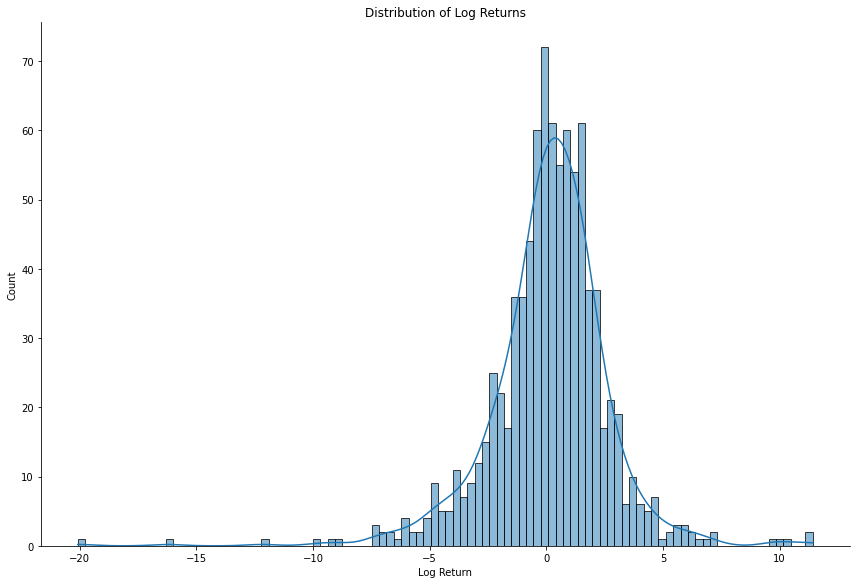


Descriptive statistics for Log Returns:
count    887.000000
mean       0.124833
std        2.563441
min      -20.083751
25%       -0.985532
50%        0.269669
75%        1.481964
max       11.423675
Name: Log Return, dtype: float64

Skewness (Log Returns):  -0.9555603534895724
Kurtosis (Log Returns):  8.240317958221539


In [115]:
# Function to plot distribution, describe statistics, and calculate skewness and kurtosis
def analyze_return_distribution(series, title):
    sns.displot(series.dropna(), bins=100, kde=True, height=8, aspect=1.5)
    plt.title(f'Distribution of {title}')
    plt.show()

    # Descriptive statistics for the returns
    print(f'\nDescriptive statistics for {title}:')
    print(series.describe())

    # Skewness and kurtosis for returns
    print(f'\nSkewness ({title}): ', skew(series.dropna()))
    print(f'Kurtosis ({title}): ', kurtosis(series.dropna()))

# Assuming you have a dataframe named sp500 with columns 'Log Return' and 'Squared Return'
analyze_return_distribution(sp500['Log Return'], 'Log Returns')
# analyze_return_distribution(sp500['Squared Return'], 'Log Returns')

In [116]:
# Find the date of highest squared return in sp500
sp500.sort_values(ascending=False, by='Squared Return')


,Date,Log Return,Squared Return,YearMonth,RV
740,2020-03-15,-9.203470,289.535432,2020-03,776.217039
741,2020-03-22,-16.227902,245.049951,2020-03,776.217039
145,2008-10-19,4.493711,227.734586,2008-10,560.384344
742,2020-03-29,9.769671,138.984228,2020-03,776.217039
150,2008-11-23,-8.761840,133.507925,2008-11,489.653814
...,...,...,...,...,...
412,2013-12-01,0.058165,0.083986,2013-12,7.333245
693,2019-04-21,-0.081889,0.083273,2019-04,3.698587
371,2013-02-17,0.122459,0.048290,2013-02,7.590694
260,2011-01-02,0.069201,0.043016,2011-01,8.126404


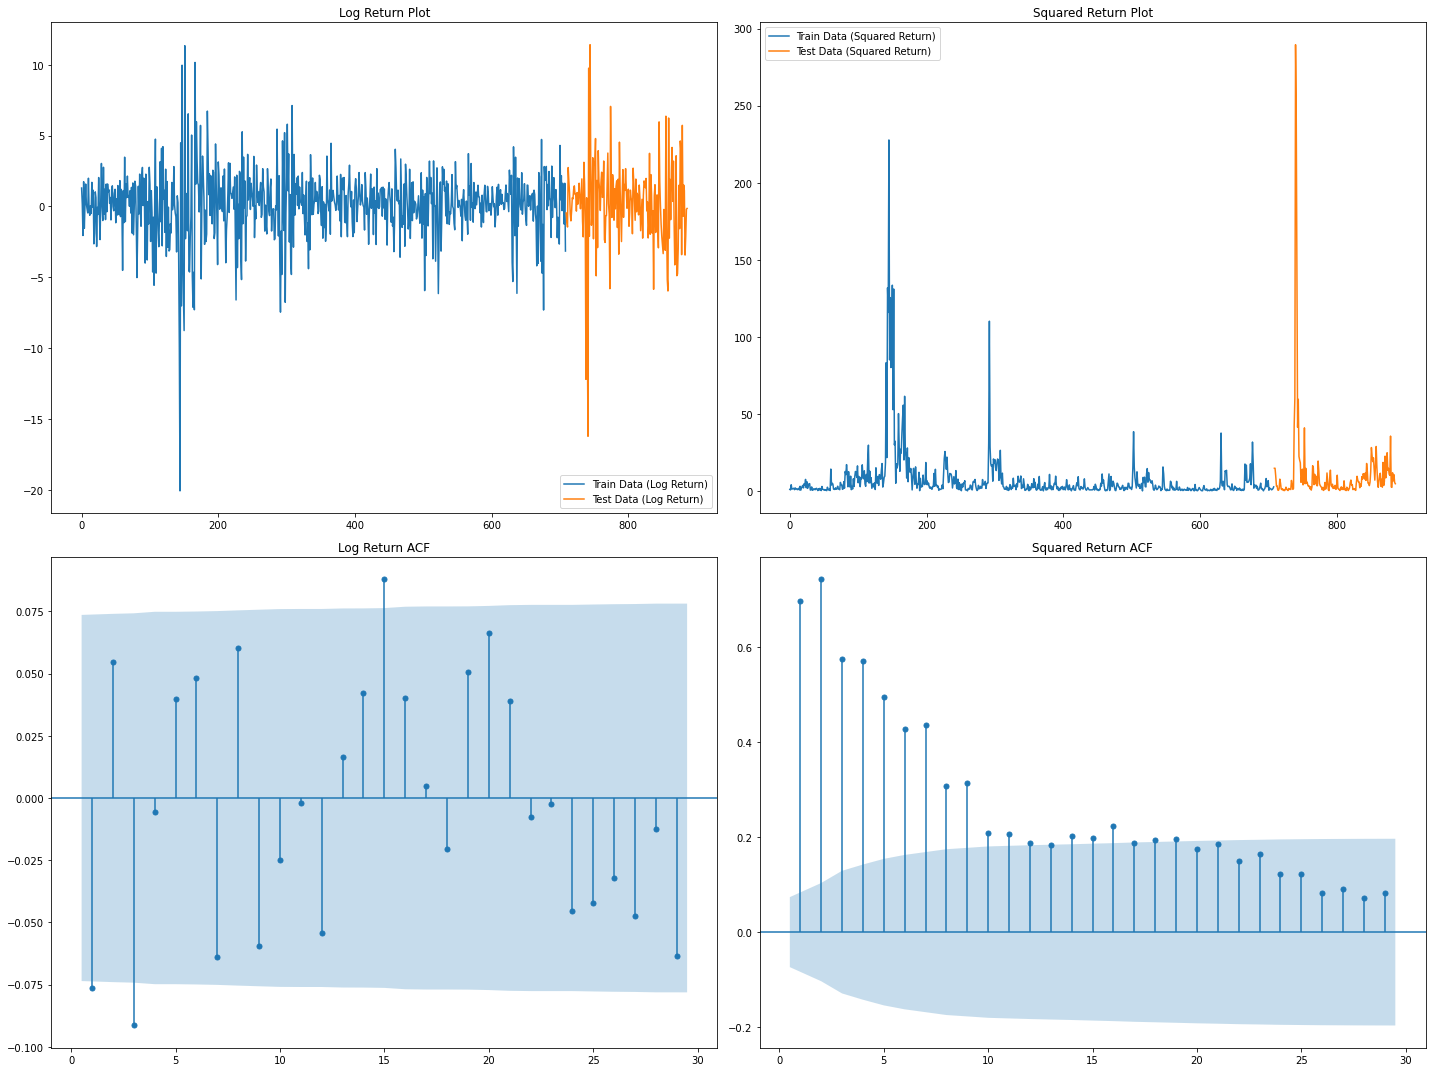

In [117]:
split = int(len(sp500) * 0.8)
train, test = sp500[:split], sp500[split:]

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# First row: Plot the train and test sets for Log Return and Squared Return
axes[0, 0].plot(train['Log Return'], label='Train Data (Log Return)')
axes[0, 0].plot(test['Log Return'], label='Test Data (Log Return)')
axes[0, 0].legend()
axes[0, 0].set_title('Log Return Plot')

axes[0, 1].plot(train['Squared Return'], label='Train Data (Squared Return)')
axes[0, 1].plot(test['Squared Return'], label='Test Data (Squared Return)')
axes[0, 1].legend()
axes[0, 1].set_title('Squared Return Plot')

# Second row: Plot the autocorrelation of the returns and squared returns
plot_acf(train['Log Return'].dropna(), ax=axes[1, 0], zero=False)
axes[1, 0].set_title('Log Return ACF')

plot_acf(train['Squared Return'].dropna(), ax=axes[1, 1], zero=False)
axes[1, 1].set_title('Squared Return ACF')

# Adjust layout for clarity
plt.tight_layout()

plt.show()


# VIsualizing low frequency data

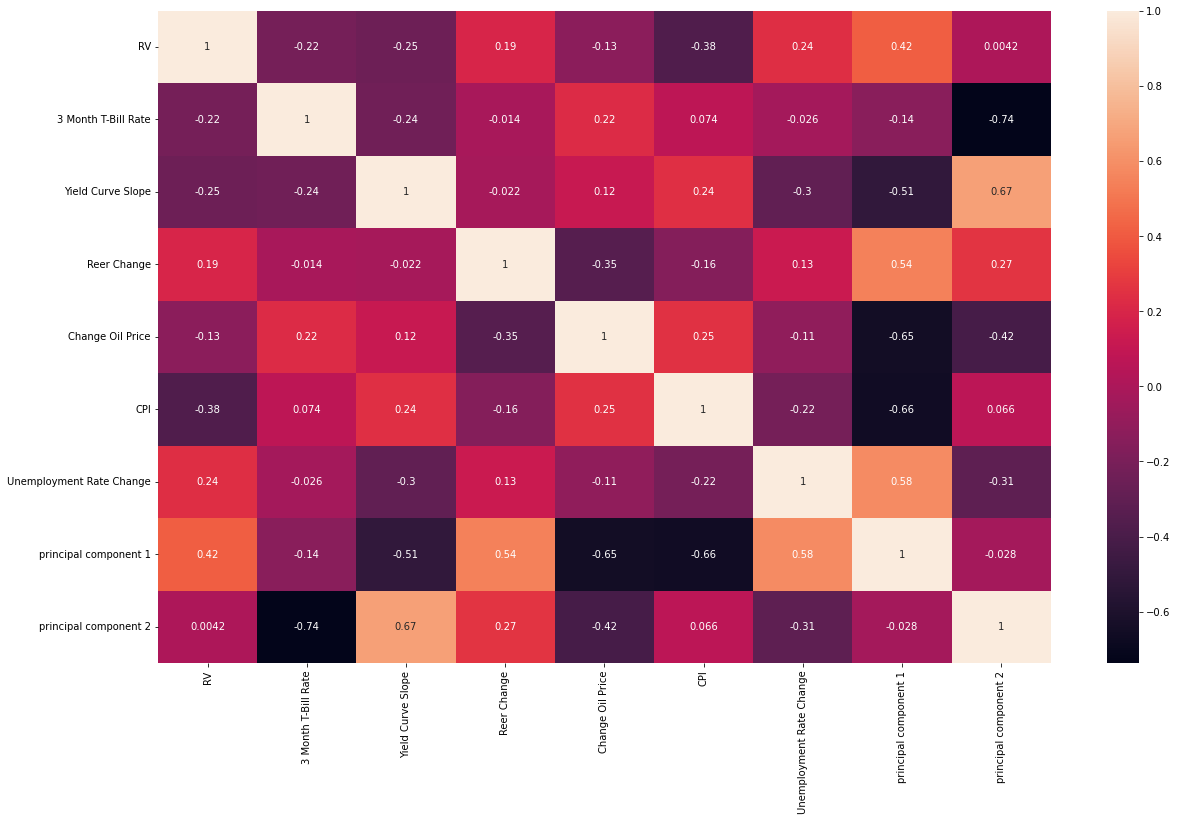

In [118]:
visualization_df = merged_df[features + ['principal component 1', 'principal component 2', 'YearMonth', 'RV']]

# Take only one row of each YearMonth
visualization_df = visualization_df.groupby('YearMonth').first()

# Visualize the correlation, make RV the first column row
visualization_df = visualization_df[['RV'] + features + ['principal component 1', 'principal component 2']]
visualization_df

# Plot the correlation matrix
plt.figure(figsize=(20, 12))
sns.heatmap(visualization_df.corr(), annot=True)
plt.show()

# Define the data to be used in the models

In [119]:
return_data = merged_df['Log Return']
volatility_data = merged_df['RV']

test_size =  169

In [120]:
# Create a GARCH(1, 1) model, first train it on train data, then test on test data

garch11_model = arch_model(return_data[:-test_size], p=1, q=1)
fixed_garch11_model = garch11_model.fit()
# garch11_model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 135112034135.82147
Iteration:      2,   Func. Count:     14,   Neg. LLF: 409449168.9909525
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1664.6219789701174
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1536.5489725522625
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1499.7344442299059
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1498.4145001729628
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1498.1538113478382
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1498.1530582113146
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1498.1530507223779
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1498.1530501850605
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1498.1530501850605
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


In [121]:
fixed_gjr_garch_model = arch_model(return_data[:-test_size], p=1, o=1, q=1).fit(disp='off')
fixed_egarch_model = arch_model(return_data[:-test_size], p=1, o=1, q=1, vol='EGARCH').fit(disp='off')
model_list = [fixed_garch11_model, fixed_egarch_model, fixed_gjr_garch_model]

# Create a function to retrieve model parameters and statistics
def get_model_params(model):
    return {
        'alpha': model.params['alpha[1]'],
        'beta': model.params['beta[1]'],
        'gamma': model.params.get('gamma[1]', 0), # If gamma doesn't exist, use 0
        'omega': model.params['omega'],
        'se_alpha': model.std_err['alpha[1]'],
        'se_beta': model.std_err['beta[1]'],
        'se_gamma': model.std_err.get('gamma[1]', 0), 
        'se_omega': model.std_err['omega'],
        't_alpha': model.tvalues['alpha[1]'],
        't_beta': model.tvalues['beta[1]'],
        't_gamma': model.tvalues.get('gamma[1]', 0), 
        't_omega': model.tvalues['omega'],
        'AIC': model.aic,
        'BIC': model.bic
    }

# Generate a DataFrame for each model and concatenate them
model_dfs = pd.concat([pd.DataFrame([get_model_params(model)]) for model in model_list], ignore_index=True)



# Extract information from fixed models

In [122]:
model_names = ["GARCH(1, 1)", "EGARCH", "GJR-GARCH"]
model_dfs.index = model_names

# Create a simple fixed parameter GARCH(1, 1) model for comparison purposes

Iteration:      1,   Func. Count:      6,   Neg. LLF: 135220218151.06015
Iteration:      2,   Func. Count:     14,   Neg. LLF: 409477686.8998394
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1666.5642380802506
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1537.8812048899838
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1501.0880402014136
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1499.7455897520085
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1499.4952004193792
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1499.4944584805014
Iteration:      9,   Func. Count:     55,   Neg. LLF: 1499.4944512867578
Iteration:     10,   Func. Count:     60,   Neg. LLF: 1499.494450739762
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1499.494450739762
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10


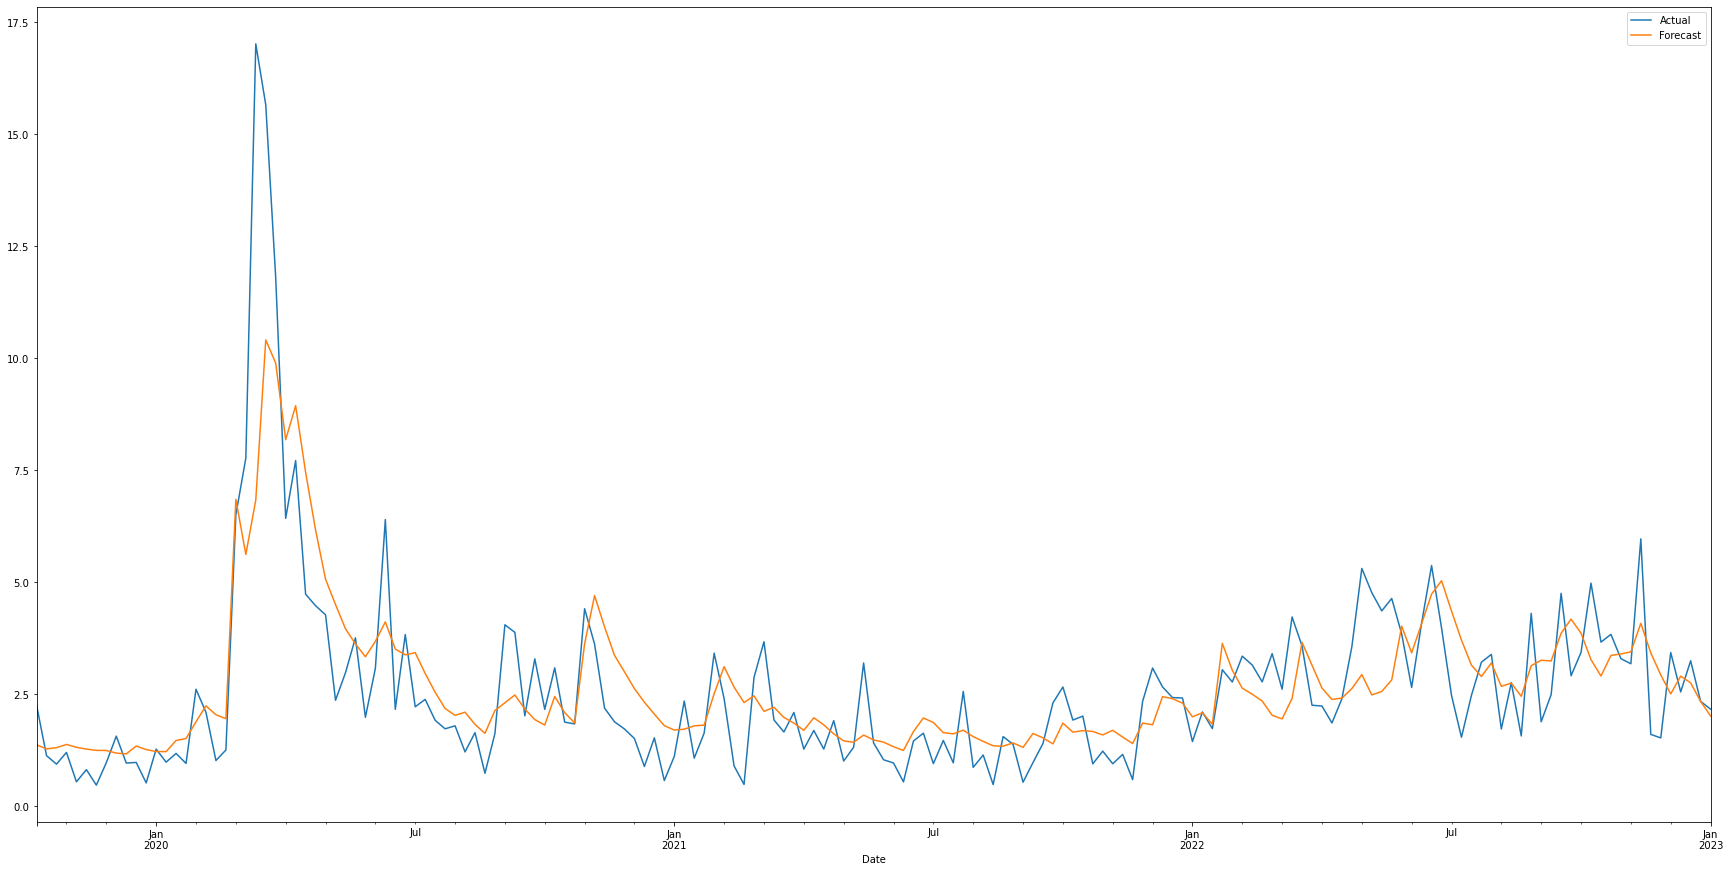

In [123]:
fixed_garch11 = arch_model(return_data, p=1, q=1)

res = fixed_garch11.fit(last_obs=715, update_freq=1)
forecasts_fixed_garch11 = res.forecast(horizon=1)
forecast_df = forecasts_fixed_garch11.variance
vol_df = pd.DataFrame(volatility_data[-test_size:])
combined_data = pd.concat([vol_df, np.sqrt(forecast_df)], axis=1)

combined_data.columns = ['Actual', 'Forecast']

# Plot the data
combined_data.plot(figsize=(30, 15))
plt.show()

# Rolling window Python GARCH models

In [124]:
# Define a function to perform rolling forecast with different GARCH models
def rolling_garch_forecast(data, test_size, garch_type='GARCH', p=1, o=0, q=1):
    rolling_predictions = []
    
    for i in range(test_size):
        train = data[:-(test_size-i)]
        if garch_type == 'GARCH':
            model = arch_model(train, p=p, q=q)
        elif garch_type == 'GJR-GARCH':
            model = arch_model(train, p=p, o=1, q=q)
        elif garch_type == 'EGARCH':
            model = arch_model(train, p=p, o=o, q=q, vol='EGARCH')
        elif garch_type == 'FIGARCH':
            model = arch_model(train, p=p, o=o, q=q, vol='FIGARCH')
        else:
            raise ValueError("Unsupported GARCH model type")
        
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1)
        rolling_predictions.append(pred.variance.values[-1,:][0])
    
    rolling_predictions = pd.Series(rolling_predictions, index=data.index[-test_size:])
    return np.sqrt(rolling_predictions)

# Function to plot the results
def plot_rolling_forecast(true_data, predicted_data, title):
    plt.figure(figsize=(12, 8))
    true, = plt.plot(true_data, label='True Values')
    preds, = plt.plot(predicted_data, label='Predictions')
    plt.title(title)
    plt.legend(handles=[true, preds])
    plt.show()

def plot_volatility(true_data, predicted_data, title):
    plt.figure(figsize=(30, 15))
    true, = plt.plot(true_data)
    preds, = plt.plot(predicted_data)
    plt.title(title)
    plt.legend(['True Values', 'Predictions'])
    plt.show()

# RNGARCH

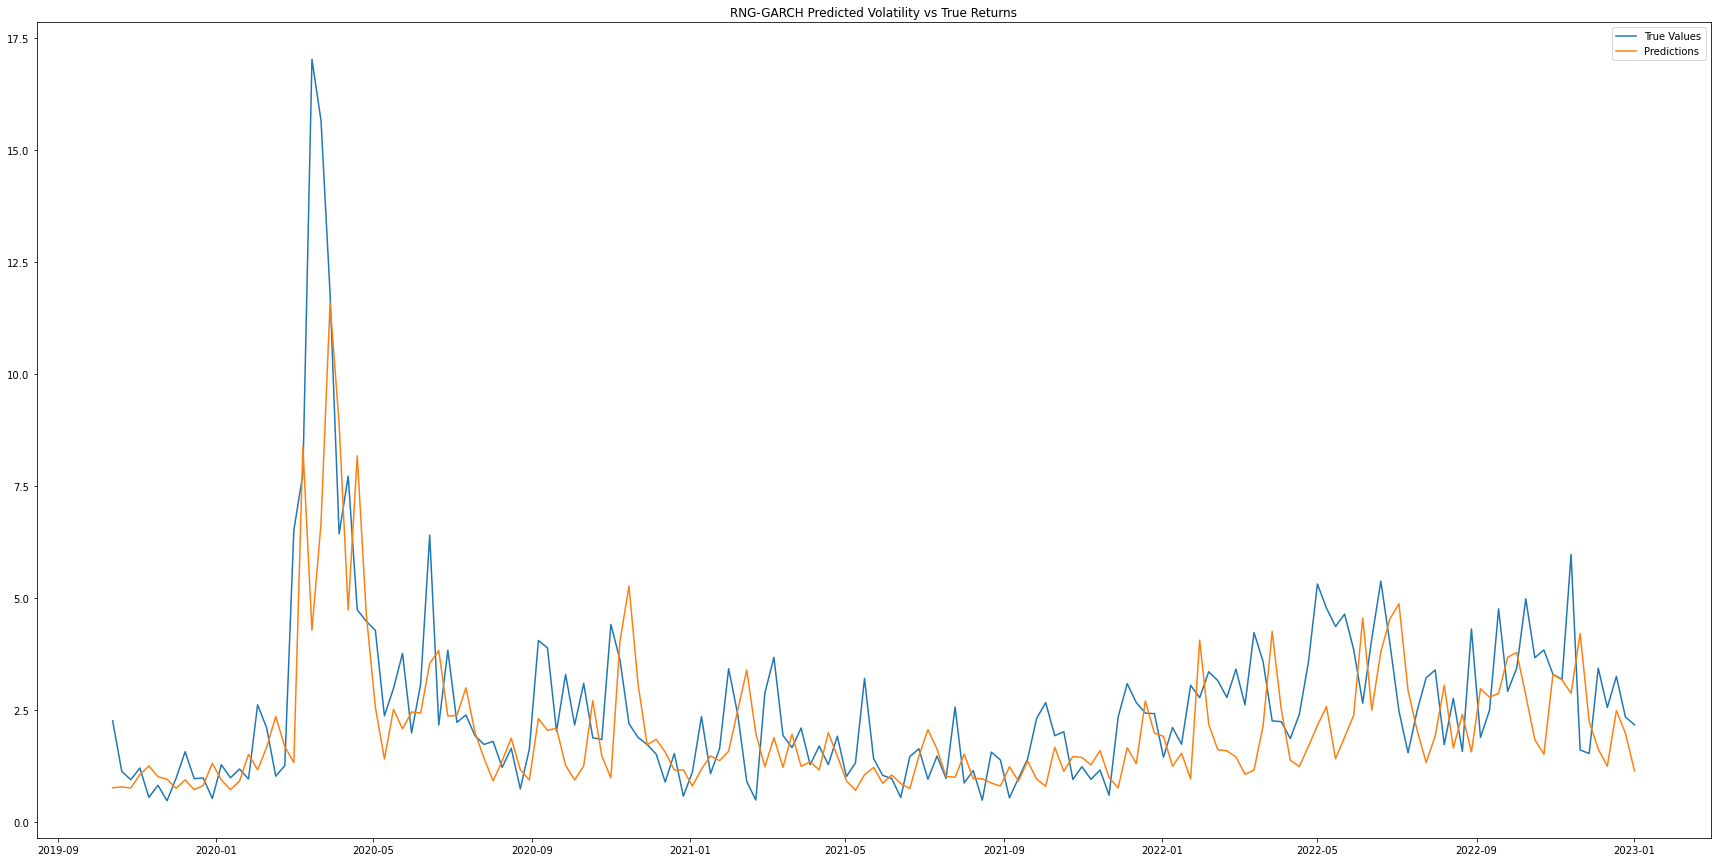

In [125]:
def garch_forecast(omega, alpha, beta, r):
    iT = len(r)
    variance = np.zeros(iT)

    for i in range(iT):
        if i == 0:
            # set initial value to long run variance
            variance[i] = omega / (1 - alpha - beta)
        else:
            # standard GARCH(1,1) recursion
            variance[i] = omega + alpha * r[i - 1] ** 2 + beta * variance[i - 1]

    return np.sqrt(variance)

# Random number generate omega, alpha, beta so that they sum up to one
omega, alpha, beta = [np.random.rand() for _i in range(3)]
standardizer_value = sum([omega, alpha, beta])

# Make sure they sum up to one
omega = omega / (standardizer_value)
alpha = alpha / (standardizer_value)
beta = beta / (standardizer_value)

forecasts = garch_forecast(omega, alpha, beta, r=return_data)

# Turn the numpy array to series
rngarch_predictions = pd.Series(forecasts, index=return_data.index)

plt.figure(figsize=(30,15))
true, = plt.plot(volatility_data[-test_size:])
preds, = plt.plot(rngarch_predictions[-test_size:])
plt.title('RNG-GARCH Predicted Volatility vs True Returns')
plt.legend(['True Values','Predictions'])

# Building the Python models

In [126]:
# Build the models
garch11_predictions = rolling_garch_forecast(return_data, test_size, 'GARCH')
gjr_garch_predictions = rolling_garch_forecast(return_data, test_size, 'GJR-GARCH')
egarch_predictions = rolling_garch_forecast(return_data, test_size, 'EGARCH')

# Importing the R models

In [127]:
midas_forecasts = pd.read_csv('data/out_of_sample_midas.csv')
r_predictions = pd.read_csv('data/out_of_sample.csv', index_col=0)
r_predictions['RV'] = r_predictions['RV']**2
r_predictions['GARCH_MIDAS'] = midas_forecasts['GARCH_MIDAS'].values
new_order = ['GARCH', 'EGARCH', 'GJR-GARCH', 'GARCH_MIDAS', 'RV']
r_predictions = r_predictions[new_order]

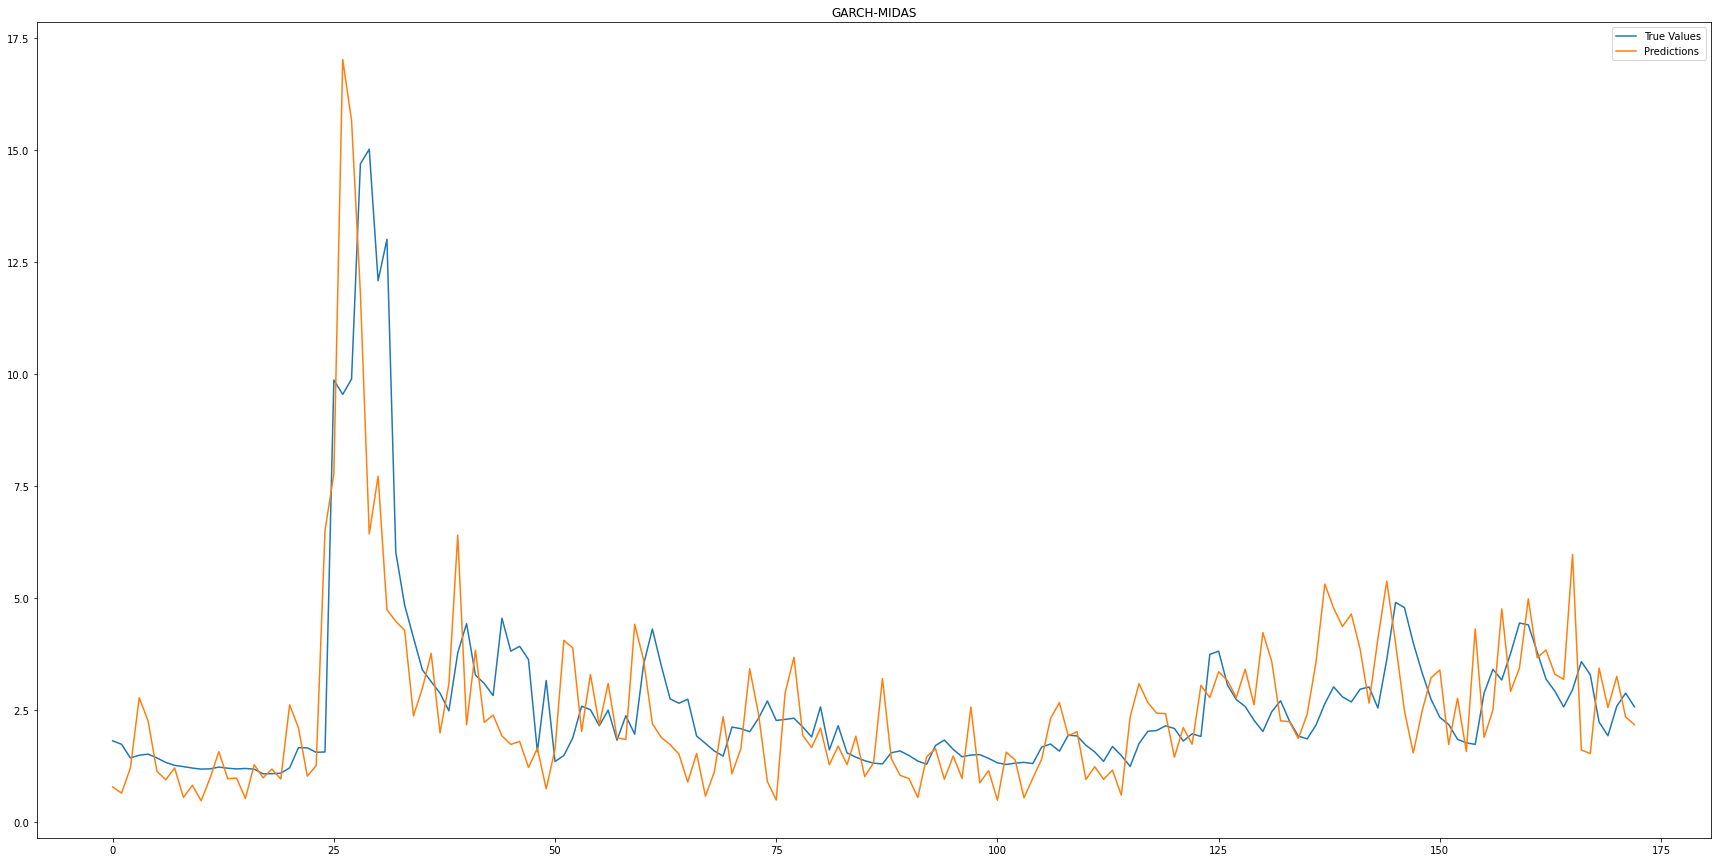

In [128]:
midas_forecasts

# Figsize 10, 5
# plt.figure(figsize=(10, 15))
plot_volatility(midas_forecasts['GARCH_MIDAS'], midas_forecasts['RV'], 'GARCH-MIDAS')

In [129]:
r_predictions

,GARCH,EGARCH,GJR-GARCH,GARCH_MIDAS,RV
2019-09-15,2.056120,1.961506,1.759090,1.805438,0.779721
2019-09-22,1.879976,1.767271,1.613117,1.730095,0.638071
2019-09-29,1.700022,1.721131,1.537558,1.424707,1.197789
2019-10-06,1.620981,1.839574,1.599996,1.484678,2.767981
2019-10-13,1.488728,1.724983,1.504064,1.509746,2.252807
...,...,...,...,...,...
2022-12-04,3.103422,2.340482,2.322184,2.224612,3.429181
2022-12-11,2.693007,2.055185,2.037498,1.920564,2.550364
2022-12-18,2.936056,3.069104,3.095966,2.578786,3.245016
2022-12-25,2.733577,3.162315,3.052909,2.871989,2.338602


# Performance Metrics

In [130]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Define your efficiency metrics functions here
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

def rmspe(actual, predicted):
    return np.sqrt(np.mean(np.square((actual - predicted) / actual)))

def mda(actual, predicted):
    return np.mean(
        (
            np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])
        ).astype(int)
    )

def r_squared(actual, predicted):
    # Need to add a constant to use OLS
    predicted = sm.add_constant(predicted)
    model = sm.OLS(actual, predicted)
    results = model.fit()
    return results.rsquared

# Define the model efficiency function
def model_efficiency(actual, predicted, title):
    return pd.DataFrame(
        {
            "MAPE": mape(actual, predicted),
            "RMSPE": rmspe(actual, predicted),
            "MDA": mda(actual, predicted),
            "R^2": r_squared(actual, predicted),
        },
        index=[title],
    )

actual_volatility = volatility_data[-test_size:].values

# Create a dictionary mapping model names to their predictions
model_predictions = {
    'GARCH(1,1)-FIXED': forecasts_fixed_garch11.variance,
    'GARCH(1,1)': garch11_predictions,
    'GJR-GARCH': gjr_garch_predictions,
    'EGARCH': egarch_predictions,
    'RNGARCH': rngarch_predictions,
    'R-GARCH': r_predictions['GARCH'],
    'R-GJR-GARCH': r_predictions['GJR-GARCH'],
    'R-EGARCH': r_predictions['EGARCH']
}

# Initialize an empty DataFrame to store efficiency metrics for all models
all_model_efficiency = pd.DataFrame()

# Loop over the dictionary and compute efficiency metrics
for model_name, predictions in model_predictions.items():
    # Compute the efficiency metrics for the current model
    efficiency = model_efficiency(actual_volatility, predictions[-test_size:].values, model_name)
    
    # Append the efficiency DataFrame to the all_model_efficiency DataFrame
    all_model_efficiency = pd.concat([all_model_efficiency, efficiency])

# Display the efficiency metrics for all models
# print(all_model_efficiency)


In [131]:
len(predictions[-test_size:].values)

169

In [132]:
display(r_predictions)

,GARCH,EGARCH,GJR-GARCH,GARCH_MIDAS,RV
2019-09-15,2.056120,1.961506,1.759090,1.805438,0.779721
2019-09-22,1.879976,1.767271,1.613117,1.730095,0.638071
2019-09-29,1.700022,1.721131,1.537558,1.424707,1.197789
2019-10-06,1.620981,1.839574,1.599996,1.484678,2.767981
2019-10-13,1.488728,1.724983,1.504064,1.509746,2.252807
...,...,...,...,...,...
2022-12-04,3.103422,2.340482,2.322184,2.224612,3.429181
2022-12-11,2.693007,2.055185,2.037498,1.920564,2.550364
2022-12-18,2.936056,3.069104,3.095966,2.578786,3.245016
2022-12-25,2.733577,3.162315,3.052909,2.871989,2.338602


# R Rolling window forecasts

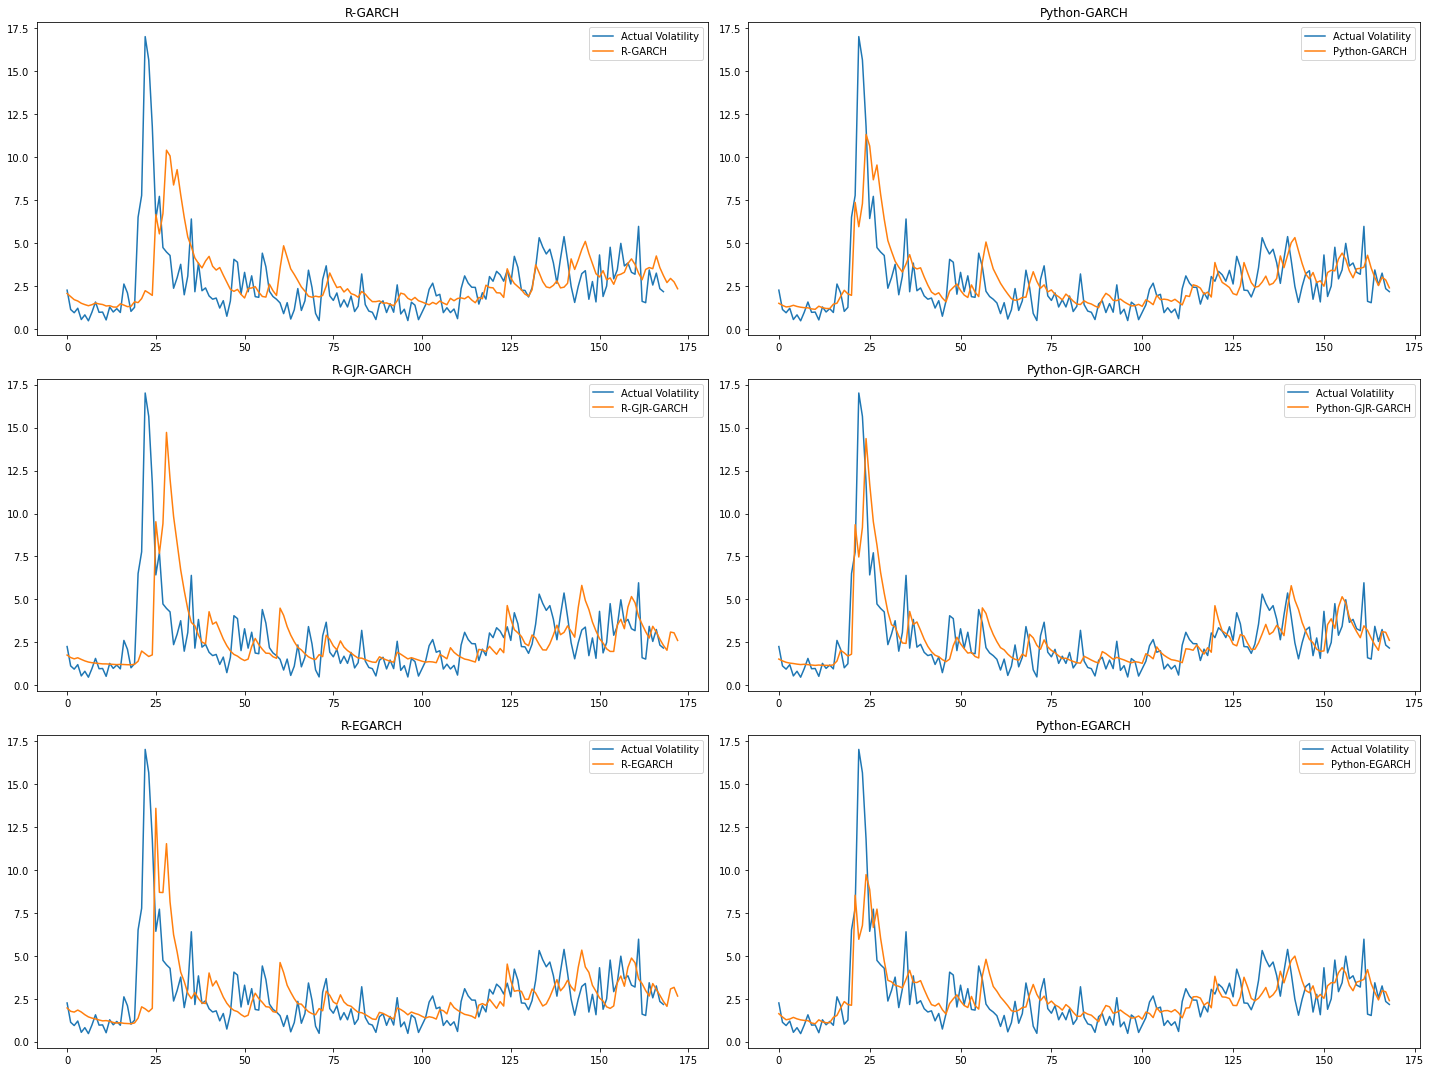

In [133]:
# Build Python model predictions
python_predictions = pd.DataFrame({
    'GARCH': rolling_garch_forecast(return_data, test_size, 'GARCH'),
    'GJR-GARCH': rolling_garch_forecast(return_data, test_size, 'GJR-GARCH'),
    'EGARCH': rolling_garch_forecast(return_data, test_size, 'EGARCH')
})

# Rename R model columns to have 'R-' prefix
r_predictions = r_predictions.rename(columns={
    'GARCH': 'R-GARCH',
    'GJR-GARCH': 'R-GJR-GARCH',
    'EGARCH': 'R-EGARCH'})

# Ensure the order of columns is the same for both DataFrames
model_names = ['GARCH', 'GJR-GARCH', 'EGARCH']  # Add or remove models as needed
r_predictions = r_predictions[['R-' + name for name in model_names if 'R-' + name in r_predictions.columns]]
python_predictions = python_predictions[[name for name in model_names if name in python_predictions.columns]]

# Transpose the plotting layout and increase the figure size
n_models = len(model_names)
fig, axs = plt.subplots(n_models, 2, figsize=(20, n_models * 5))  # Adjust figsize as needed

for i, model_name in enumerate(model_names):
    # R model plot
    r_model_name = f'R-{model_name}'
    if r_model_name in r_predictions.columns:
        axs[i, 0].plot(actual_volatility[-test_size:], label='Actual Volatility')
        axs[i, 0].plot(r_predictions[r_model_name].values, label=r_model_name)
        axs[i, 0].set_title(r_model_name)
        axs[i, 0].legend()

    # Python model plot
    if model_name in python_predictions.columns:  # Check if model exists in Python predictions
        axs[i, 1].plot(actual_volatility[-test_size:], label='Actual Volatility')
        axs[i, 1].plot(python_predictions[model_name].values, label=f'Python-{model_name}')
        axs[i, 1].set_title(f'Python-{model_name}')
        axs[i, 1].legend()

plt.tight_layout()
plt.show()

# Model fit

In [134]:
r_model_fit_data = pd.read_csv('data/model_fit.csv').drop(columns=['Unnamed: 0'])
r_model_fit_data = r_model_fit_data.rename(columns={'gamma': 'omega', 'omega': 'gamma'})
r_model_fit_data.index = ['R-GARCH(1, 1)', 'R-EGARCH', 'R-GJR-GARCH']

In [135]:
model_fit_comparisons = pd.concat([model_dfs, r_model_fit_data])
# model_fit_comparisons.to_csv('data/model_fit_comparisons.csv')
model_fit_comparisons

,alpha,beta,gamma,omega,se_alpha,se_beta,se_gamma,se_omega,t_alpha,t_beta,t_gamma,t_omega,AIC,BIC
"GARCH(1, 1)",0.281643,0.665035,0.000000,0.372801,0.072577,0.065607,0.000000,0.125047,3.880588,10.136584,0.000000,2.981294,3004.306100,3022.589632
EGARCH,0.353259,0.881065,-0.232759,0.164282,0.085397,0.038837,0.050744,0.058337,4.136679,22.686216,-4.586925,2.816084,2969.691871,2992.546285
GJR-GARCH,0.028998,0.689999,0.407658,0.404345,0.038743,0.073033,0.114253,0.128531,0.748461,9.447771,3.568021,3.145881,2971.952427,2994.806842
"R-GARCH(1, 1)",0.359759,0.243979,0.000000,0.698845,0.107688,0.042534,0.046633,0.000000,3.340760,5.736090,14.986065,0.000000,4.238827,4.258032
R-EGARCH,0.190255,-0.253770,0.337690,0.874725,0.037351,0.034811,0.024925,0.055871,5.093757,-7.290016,35.094450,6.044149,4.169079,4.194686
R-GJR-GARCH,0.430615,0.015458,0.450148,0.698310,0.090107,0.030679,0.045238,0.083511,4.778910,0.503853,15.436411,5.390313,4.173774,4.199381


In [136]:
# all_model_efficiency.concat(r_model_fit_data, axis=1)
# print(round(all_model_efficiency, 3))
display(all_model_efficiency)


all_model_efficiency.to_csv('data/all_model_efficiency.csv')


,MAPE,RMSPE,MDA,R^2
"GARCH(1,1)-FIXED",4.845454,12.479160,0.535927,0.644509
"GARCH(1,1)",0.521406,0.789204,0.648810,0.427058
GJR-GARCH,0.444499,0.654882,0.696429,0.539270
EGARCH,0.513586,0.782608,0.654762,0.471794
RNGARCH,0.467062,0.618513,0.619048,0.377693
R-GARCH,0.556429,0.834807,0.642857,0.391919
R-GJR-GARCH,0.448219,0.657382,0.684524,0.540046
R-EGARCH,0.435267,0.653555,0.708333,0.582983
